In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/preprocessed_daily_transport_journeys.csv')
df.head()

,Date,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
0,2019-07-01,15987,9962.0,407.0,21223.0,3715.0,1.0
1,2019-07-02,16895,10656.0,409.0,21715.0,3993.0,1.0
2,2019-07-03,16613,10658.0,427.0,22025.0,3638.0,1.0
3,2019-07-04,16604,10445.0,437.0,21868.0,3576.0,1.0
4,2019-07-05,16040,10532.0,400.0,20697.0,2856.0,1.0


In [3]:
start_date = df['Date'].min()
end_date = df['Date'].max()

Total Daily Passengers and its analysis

In [4]:
df['Total_Daily'] = (df['Local Route'] + df['Light Rail'] +
                     df['Peak Service'] + df['Rapid Route'] +
                     df['School'] + df['Other'])

In [5]:
total_passengers = df['Total_Daily'].sum()
avg_daily = df['Total_Daily'].mean()
median_daily = df['Total_Daily'].median()
max_daily = df['Total_Daily'].max()
min_daily = df['Total_Daily'].min()
std_dev = df['Total_Daily'].std()
cv = (std_dev / avg_daily) * 100

print(f"\nTotal passengers (entire period): {total_passengers:,.0f}")
print(f"Average daily passengers: {avg_daily:,.0f}")
print(f"Median daily passengers: {median_daily:,.0f}")
print(f"Max daily passengers: {max_daily:,.0f}")
print(f"Min daily passengers: {min_daily:,.0f}")
print(f"Std Dev: {std_dev:,.0f}")
print(f"Coefficient of Variation: {cv:.1f}%")


Total passengers (entire period): 64,245,624
Average daily passengers: 33,689
Median daily passengers: 35,218
Max daily passengers: 69,754
Min daily passengers: 178
Std Dev: 16,958
Coefficient of Variation: 50.3%


In [6]:
df['Total_Daily'].describe()

,Total_Daily
count,1907.000000
mean,33689.367593
std,16957.771658
min,178.000000
25%,18253.500000
50%,35218.000000
75%,48411.000000
max,69754.000000


Calculate totals and percentages

In [7]:
service_columns = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School', 'Other']
service_totals = df[service_columns].sum()
service_pct = (service_totals / service_totals.sum() * 100).round(1)

print("\nTotal passengers by service type:")
for service in service_columns:
    total = service_totals[service]
    pct = service_pct[service]
    print(f"  {service:20s}: {total:12,.0f} ({pct:5.1f}%)")

dominant_service = service_totals.idxmax()
print(f"\n✓ {dominant_service} dominates with {service_pct[dominant_service]:.1f}% of all journeys")


Total passengers by service type:
  Local Route         :   18,807,593 ( 29.3%)
  Light Rail          :   13,693,979 ( 21.3%)
  Peak Service        :      497,623 (  0.8%)
  Rapid Route         :   23,963,159 ( 37.3%)
  School              :    7,201,488 ( 11.2%)
  Other               :       81,782 (  0.1%)

✓ Rapid Route dominates with 37.3% of all journeys


Create summary dataframe

In [8]:
service_summary = pd.DataFrame({
    'Service Type': service_columns,
    'Total Passengers': service_totals.values,
    'Percentage': service_pct.values
}).sort_values('Percentage', ascending=False)

print("\nService Summary (ranked):")
print(service_summary)


Service Summary (ranked):
   Service Type  Total Passengers  Percentage
3   Rapid Route        23963159.0        37.3
0   Local Route        18807593.0        29.3
1    Light Rail        13693979.0        21.3
4        School         7201488.0        11.2
2  Peak Service          497623.0         0.8
5         Other           81782.0         0.1


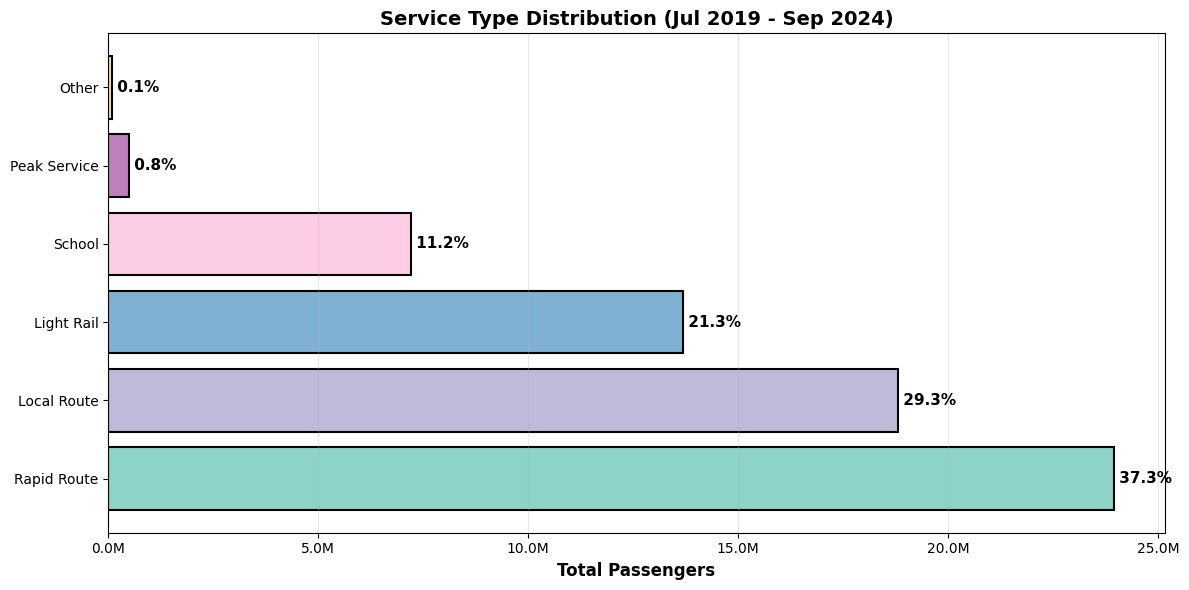

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.Set3(np.linspace(0, 1, len(service_columns)))
bars = ax.barh(service_summary['Service Type'], service_summary['Total Passengers'],
               color=colors, edgecolor='black', linewidth=1.5)

# Add percentage labels on bars
for i, (bar, pct) in enumerate(zip(bars, service_summary['Percentage'])):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2,
           f' {pct:.1f}%', ha='left', va='center', fontweight='bold', fontsize=11)

ax.set_xlabel('Total Passengers', fontsize=12, fontweight='bold')
ax.set_title('Service Type Distribution (Jul 2019 - Sep 2024)', fontsize=14, fontweight='bold')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('01_service_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

Rapid Route dominates with 37.3% of all journeys,followed by Local Routes (29.3%) and Light Rail (21.3%)
# Insight 1
**Rapid route leads public transport usage**

# Trend Analysis

In [12]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year

# Calculate annual summary
yearly_summary = df.groupby('Year')['Total_Daily'].agg(['sum', 'mean', 'std', 'count'])
yearly_summary.columns = ['Total_Passengers', 'Avg_Daily', 'Std_Dev', 'Days']

print("\nAnnual Summary:")
print(yearly_summary)


Annual Summary:
      Total_Passengers     Avg_Daily       Std_Dev  Days
Year                                                    
2019         8559569.0  46773.601093  18126.491512   183
2020        10125660.0  27741.534247  16291.416457   365
2021         9817646.0  26971.554945  16481.352948   364
2022        11260357.0  31020.267218  12489.201393   363
2023        13765486.0  38343.972145  14887.291181   359
2024        10716906.0  39256.065934  16911.016741   273


In [13]:
#year-on-year growth
for i in range(1, len(yearly_summary)):
    prev_year = yearly_summary.index[i-1]
    curr_year = yearly_summary.index[i]
    prev_total = yearly_summary.loc[prev_year, 'Total_Passengers']
    curr_total = yearly_summary.loc[curr_year, 'Total_Passengers']
    growth = ((curr_total - prev_total) / prev_total) * 100
    print(f"  {prev_year} → {curr_year}: {growth:+.1f}%")

# Overall growth
first_year_avg = df[df['Year'] == df['Year'].min()]['Total_Daily'].mean()
last_year_avg = df[df['Year'] == df['Year'].max()]['Total_Daily'].mean()
overall_growth = ((last_year_avg - first_year_avg) / first_year_avg) * 100

print(f"\nFirst year average (2019): {first_year_avg:,.0f}")
print(f"Last year average (2024): {last_year_avg:,.0f}")
print(f"Overall growth: {overall_growth:+.1f}%")

  2019 → 2020: +18.3%
  2020 → 2021: -3.0%
  2021 → 2022: +14.7%
  2022 → 2023: +22.2%
  2023 → 2024: -22.1%

First year average (2019): 46,774
Last year average (2024): 39,256
Overall growth: -16.1%


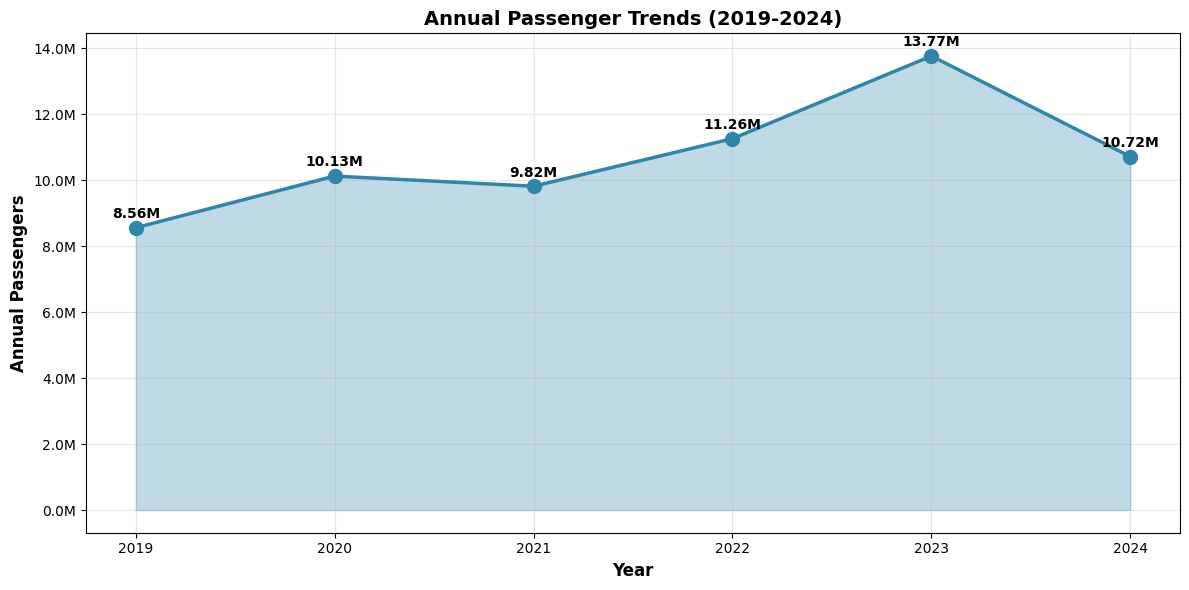

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))

years = yearly_summary.index
passengers = yearly_summary['Total_Passengers'].values

ax.plot(years, passengers, marker='o', linewidth=2.5, markersize=10, color='#2E86AB')
ax.fill_between(years, passengers, alpha=0.3, color='#2E86AB')

# Add value labels on each point
for year, passenger in zip(years, passengers):
    ax.text(year, passenger + 200000, f'{passenger/1e6:.2f}M',
           ha='center', va='bottom', fontweight='bold', fontsize=10)

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Annual Passengers', fontsize=12, fontweight='bold')
ax.set_title('Annual Passenger Trends (2019-2024)', fontsize=14, fontweight='bold')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
ax.grid(True, alpha=0.3)
ax.set_xticks(years)

plt.tight_layout()
plt.savefig('02_annual_trends.png', dpi=300, bbox_inches='tight')
plt.show()

**Annual passengers peaked in 2023 at 13.8M then declined 22.1% in 2024**

# Weekly Passenger Pattern

In [15]:
# Add day of week
df['DayOfWeek'] = df['Date'].dt.day_name()

# Calculate weekly statistics
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_stats = df.groupby('DayOfWeek')['Total_Daily'].agg(['mean', 'median', 'std', 'min', 'max'])
weekly_stats = weekly_stats.reindex(day_order)

print("\nDaily passenger statistics by day of week:")
print(weekly_stats.round(0))


Daily passenger statistics by day of week:
              mean   median      std     min      max
DayOfWeek                                            
Monday     36860.0  39928.0  15654.0  2165.0  66306.0
Tuesday    42059.0  44636.0  14851.0   232.0  69691.0
Wednesday  42238.0  44234.0  14937.0   211.0  69343.0
Thursday   41545.0  43966.0  14665.0   196.0  69754.0
Friday     39730.0  42034.0  14820.0   193.0  68895.0
Saturday   18753.0  19420.0   6181.0   179.0  34761.0
Sunday     14806.0  15399.0   4825.0   178.0  24169.0


In [16]:
# Weekday vs Weekend
weekday_data = df[df['DayOfWeek'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]
weekend_data = df[df['DayOfWeek'].isin(['Saturday', 'Sunday'])]

weekday_avg = weekday_data['Total_Daily'].mean()
weekend_avg = weekend_data['Total_Daily'].mean()
diff_pct = ((weekday_avg - weekend_avg) / weekend_avg) * 100

print(f"\nWeekday average: {weekday_avg:,.0f} passengers")
print(f"Weekend average: {weekend_avg:,.0f} passengers")
print(f"Difference: {diff_pct:+.1f}% (weekdays are {diff_pct:.0f}% higher)")


Weekday average: 40,489 passengers
Weekend average: 16,783 passengers
Difference: +141.3% (weekdays are 141% higher)


In [17]:
# Find best and worst days
best_day = weekly_stats['mean'].idxmax()
worst_day = weekly_stats['mean'].idxmin()

print(f"\n✓ Best day: {best_day} ({weekly_stats.loc[best_day, 'mean']:,.0f} avg)")
print(f"✓ Worst day: {worst_day} ({weekly_stats.loc[worst_day, 'mean']:,.0f} avg)")


✓ Best day: Wednesday (42,238 avg)
✓ Worst day: Sunday (14,806 avg)


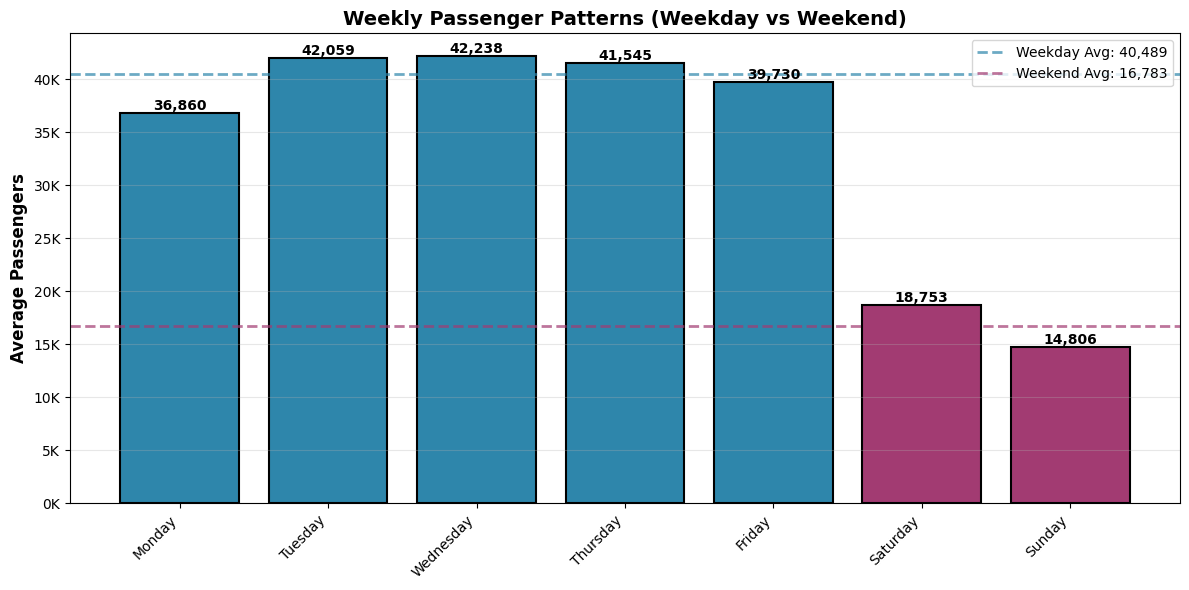

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

days = weekly_stats.index
values = weekly_stats['mean'].values

# Color weekdays differently from weekends
colors = ['#2E86AB' if day != 'Saturday' and day != 'Sunday' else '#A23B72' for day in days]

bars = ax.bar(range(len(days)), values, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height,
           f'{value:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

ax.set_ylabel('Average Passengers', fontsize=12, fontweight='bold')
ax.set_title('Weekly Passenger Patterns (Weekday vs Weekend)', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(days)))
ax.set_xticklabels(days, rotation=45, ha='right')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))

# Add reference lines
ax.axhline(y=weekday_avg, color='#2E86AB', linestyle='--', linewidth=2,
          label=f'Weekday Avg: {weekday_avg:,.0f}', alpha=0.7)
ax.axhline(y=weekend_avg, color='#A23B72', linestyle='--', linewidth=2,
          label=f'Weekend Avg: {weekend_avg:,.0f}', alpha=0.7)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('03_weekly_patterns.png', dpi=300, bbox_inches='tight')
plt.show()


**Weekday commute traffic is 141% higher than weekends, peaking on Wednesday (42,238 avg)**

In [19]:
df['Month'] = df['Date'].dt.month
df['Month_Name'] = df['Date'].dt.strftime('%B')

# Calculate monthly statistics
monthly_avg = df.groupby('Month')['Total_Daily'].mean()
monthly_summary = df.groupby(['Month', 'Month_Name'])['Total_Daily'].agg(['mean', 'median', 'std', 'min', 'max'])

month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
               7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

print("\nAverage daily passengers by month (ranked):")
monthly_ranked = monthly_avg.sort_values(ascending=False)
for month_num, avg in monthly_ranked.items():
    month_name = month_names[month_num]
    print(f"  {month_name:12s} (M{month_num:2d}): {avg:,.0f}")


Average daily passengers by month (ranked):
  February     (M 2): 43,266
  March        (M 3): 39,435
  November     (M11): 37,212
  August       (M 8): 36,526
  July         (M 7): 34,798
  May          (M 5): 34,203
  June         (M 6): 33,513
  October      (M10): 33,349
  September    (M 9): 31,919
  April        (M 4): 28,314
  December     (M12): 27,790
  January      (M 1): 24,433


In [20]:
# Find peak and low months
peak_month = monthly_avg.idxmax()
low_month = monthly_avg.idxmin()
peak_diff = ((monthly_avg[peak_month] - monthly_avg[low_month]) / monthly_avg[low_month]) * 100

print(f"\n✓ Peak month: {month_names[peak_month]} ({monthly_avg[peak_month]:,.0f} daily avg)")
print(f"✓ Lowest month: {month_names[low_month]} ({monthly_avg[low_month]:,.0f} daily avg)")
print(f"✓ Seasonal variation: {peak_diff:.1f}% difference between peak and low")


✓ Peak month: February (43,266 daily avg)
✓ Lowest month: January (24,433 daily avg)
✓ Seasonal variation: 77.1% difference between peak and low


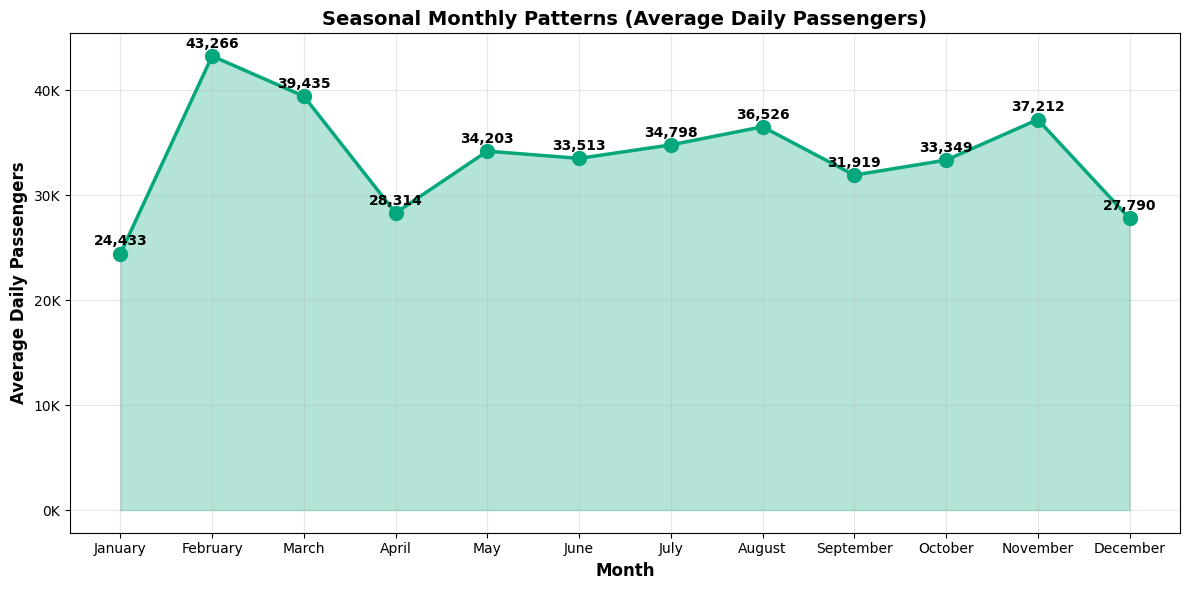

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))

# Sort by month number
monthly_sorted = monthly_avg.sort_index()

ax.plot(range(1, 13), monthly_sorted.values, marker='o', linewidth=2.5,
       markersize=10, color='#06A77D')
ax.fill_between(range(1, 13), monthly_sorted.values, alpha=0.3, color='#06A77D')

# Add value labels
for month, value in enumerate(monthly_sorted.values, 1):
    ax.text(month, value + 500, f'{value:,.0f}', ha='center', va='bottom',
           fontweight='bold', fontsize=10)

ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Daily Passengers', fontsize=12, fontweight='bold')
ax.set_title('Seasonal Monthly Patterns (Average Daily Passengers)', fontsize=14, fontweight='bold')
ax.set_xticks(range(1, 13))
ax.set_xticklabels([month_names[i] for i in range(1, 13)])
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('04_monthly_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

Anomaly and Extreme events

In [22]:
# Identify extremely low days
threshold_low = df['Total_Daily'].quantile(0.05)
low_days = df[df['Total_Daily'] < threshold_low].sort_values('Total_Daily')

print(f"\nBottom 5 lowest activity days (< {threshold_low:,.0f} passengers):")
for idx, row in low_days.head(5).iterrows():
    date_str = row['Date'].strftime('%Y-%m-%d (%A)')
    print(f"  {date_str}: {row['Total_Daily']:,.0f} passengers")

# Identify peak days
threshold_high = df['Total_Daily'].quantile(0.95)
high_days = df[df['Total_Daily'] > threshold_high].sort_values('Total_Daily', ascending=False)

print(f"\nTop 5 highest activity days (> {threshold_high:,.0f} passengers):")
for idx, row in high_days.head(5).iterrows():
    date_str = row['Date'].strftime('%Y-%m-%d (%A)')
    print(f"  {date_str}: {row['Total_Daily']:,.0f} passengers")

print(f"\nDay distribution analysis:")
print(f"  Extremely low days (bottom 5%): {len(low_days)} days")
print(f"  Extremely high days (top 5%): {len(high_days)} days")


Bottom 5 lowest activity days (< 7,742 passengers):
  2024-09-29 (Sunday): 178 passengers
  2024-09-28 (Saturday): 179 passengers
  2024-09-27 (Friday): 193 passengers
  2024-09-26 (Thursday): 196 passengers
  2024-09-25 (Wednesday): 211 passengers

Top 5 highest activity days (> 60,383 passengers):
  2020-02-27 (Thursday): 69,754 passengers
  2020-02-25 (Tuesday): 69,691 passengers
  2020-02-26 (Wednesday): 69,343 passengers
  2020-02-21 (Friday): 68,895 passengers
  2020-02-28 (Friday): 68,767 passengers

Day distribution analysis:
  Extremely low days (bottom 5%): 96 days
  Extremely high days (top 5%): 96 days


# Service Type Volatility

In [23]:
volatility_data = []
for service in service_columns:
    mean_val = df[service].mean()
    std_val = df[service].std()
    cv = (std_val / mean_val) * 100
    volatility_data.append({
        'Service': service,
        'Mean': mean_val,
        'Std Dev': std_val,
        'CV%': cv
    })
    print(f"  {service:20s}: {cv:6.1f}% CV  (Mean: {mean_val:8,.0f}, StdDev: {std_val:8,.0f})")

volatility_df = pd.DataFrame(volatility_data).sort_values('CV%', ascending=False)

print(f"\n✓ Most stable: {volatility_df.iloc[-1]['Service']} ({volatility_df.iloc[-1]['CV%']:.1f}% CV)")
print(f"✓ Most volatile: {volatility_df.iloc[0]['Service']} ({volatility_df.iloc[0]['CV%']:.1f}% CV)")

  Local Route         :   62.0% CV  (Mean:    9,862, StdDev:    6,118)
  Light Rail          :   46.5% CV  (Mean:    7,181, StdDev:    3,340)
  Peak Service        :   45.5% CV  (Mean:      261, StdDev:      119)
  Rapid Route         :   53.5% CV  (Mean:   12,566, StdDev:    6,718)
  School              :   51.8% CV  (Mean:    3,776, StdDev:    1,955)
  Other               :   76.6% CV  (Mean:       43, StdDev:       33)

✓ Most stable: Peak Service (45.5% CV)
✓ Most volatile: Other (76.6% CV)


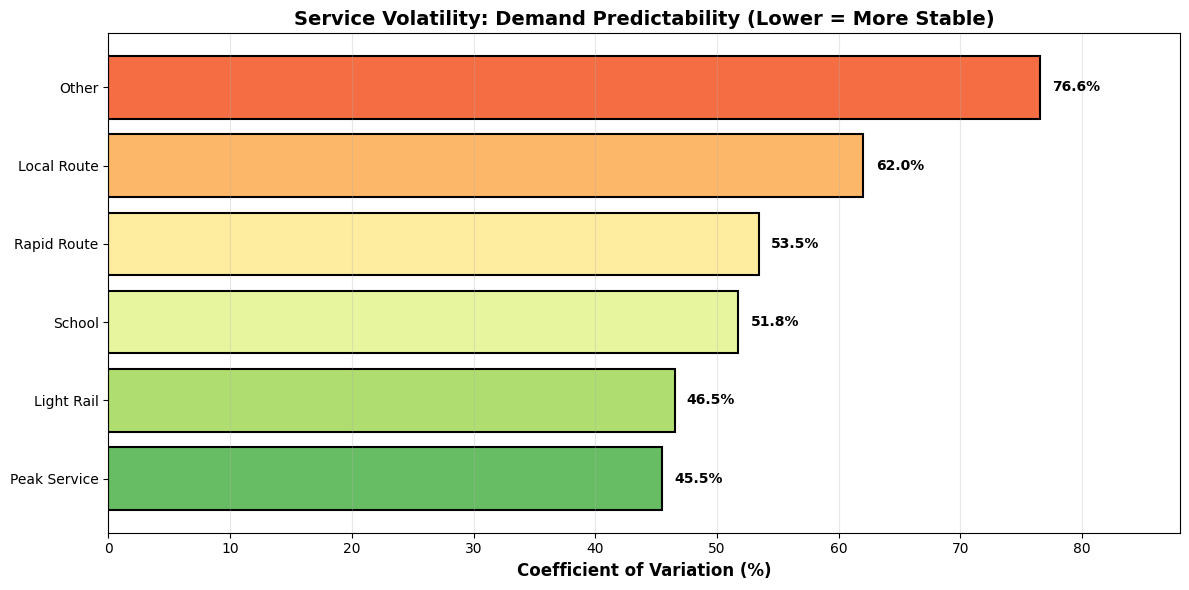

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))

# Sort by CV percentage
volatility_sorted = volatility_df.sort_values('CV%')

colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(volatility_sorted)))

bars = ax.barh(volatility_sorted['Service'], volatility_sorted['CV%'],
               color=colors, edgecolor='black', linewidth=1.5)

# Add value labels
for bar, value in zip(bars, volatility_sorted['CV%']):
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height()/2,
           f'{value:.1f}%', ha='left', va='center', fontweight='bold', fontsize=10)

ax.set_xlabel('Coefficient of Variation (%)', fontsize=12, fontweight='bold')
ax.set_title('Service Volatility: Demand Predictability (Lower = More Stable)',
            fontsize=14, fontweight='bold')
ax.set_xlim(0, max(volatility_sorted['CV%']) * 1.15)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('05_service_volatility.png', dpi=300, bbox_inches='tight')
plt.show()

# Service Correlation

In [25]:
corr_matrix = df[service_columns].corr()

print("\nCorrelation between service types (1.0 = perfect correlation):")
print("\nHighest correlations (pairs):")

# Get upper triangle of correlation matrix
corr_pairs = []
for i in range(len(service_columns)):
    for j in range(i+1, len(service_columns)):
        corr_pairs.append({
            'Service1': service_columns[i],
            'Service2': service_columns[j],
            'Correlation': corr_matrix.iloc[i, j]
        })

corr_pairs_sorted = sorted(corr_pairs, key=lambda x: x['Correlation'], reverse=True)
for pair in corr_pairs_sorted:
    print(f"  {pair['Service1']:20s} ↔ {pair['Service2']:20s}: {pair['Correlation']:.3f}")

print("\nFull correlation matrix:")
print(corr_matrix.round(3))


Correlation between service types (1.0 = perfect correlation):

Highest correlations (pairs):
  Light Rail           ↔ Rapid Route         : 0.967
  Local Route          ↔ Rapid Route         : 0.965
  Local Route          ↔ Light Rail          : 0.918
  Light Rail           ↔ Peak Service        : 0.653
  Peak Service         ↔ Rapid Route         : 0.611
  Local Route          ↔ Other               : 0.569
  Peak Service         ↔ School              : 0.518
  Light Rail           ↔ Other               : 0.504
  Local Route          ↔ Peak Service        : 0.465
  Rapid Route          ↔ Other               : 0.462
  Rapid Route          ↔ School              : 0.427
  Local Route          ↔ School              : 0.420
  Light Rail           ↔ School              : 0.419
  School               ↔ Other               : 0.189
  Peak Service         ↔ Other               : 0.104

Full correlation matrix:
              Local Route  Light Rail  Peak Service  Rapid Route  School  \
Local Ro

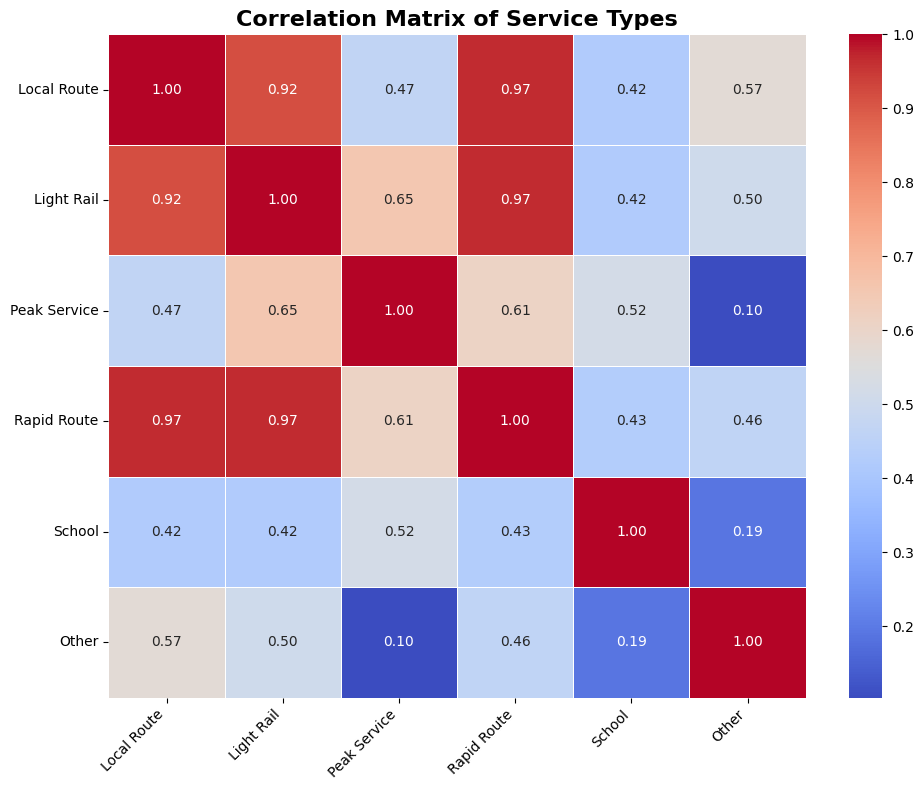

In [26]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Service Types', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('06_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()